# Runing the adaptive speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import xarray as xr
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.fastscape_ext import adaspec_IR12_model

## Speciation without competition in an evolving landscape

In [2]:
adaspec_IR12_model

<xsimlab.Model (24 processes, 50 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
init_erosion
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] background, non-orographic precipit...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallou

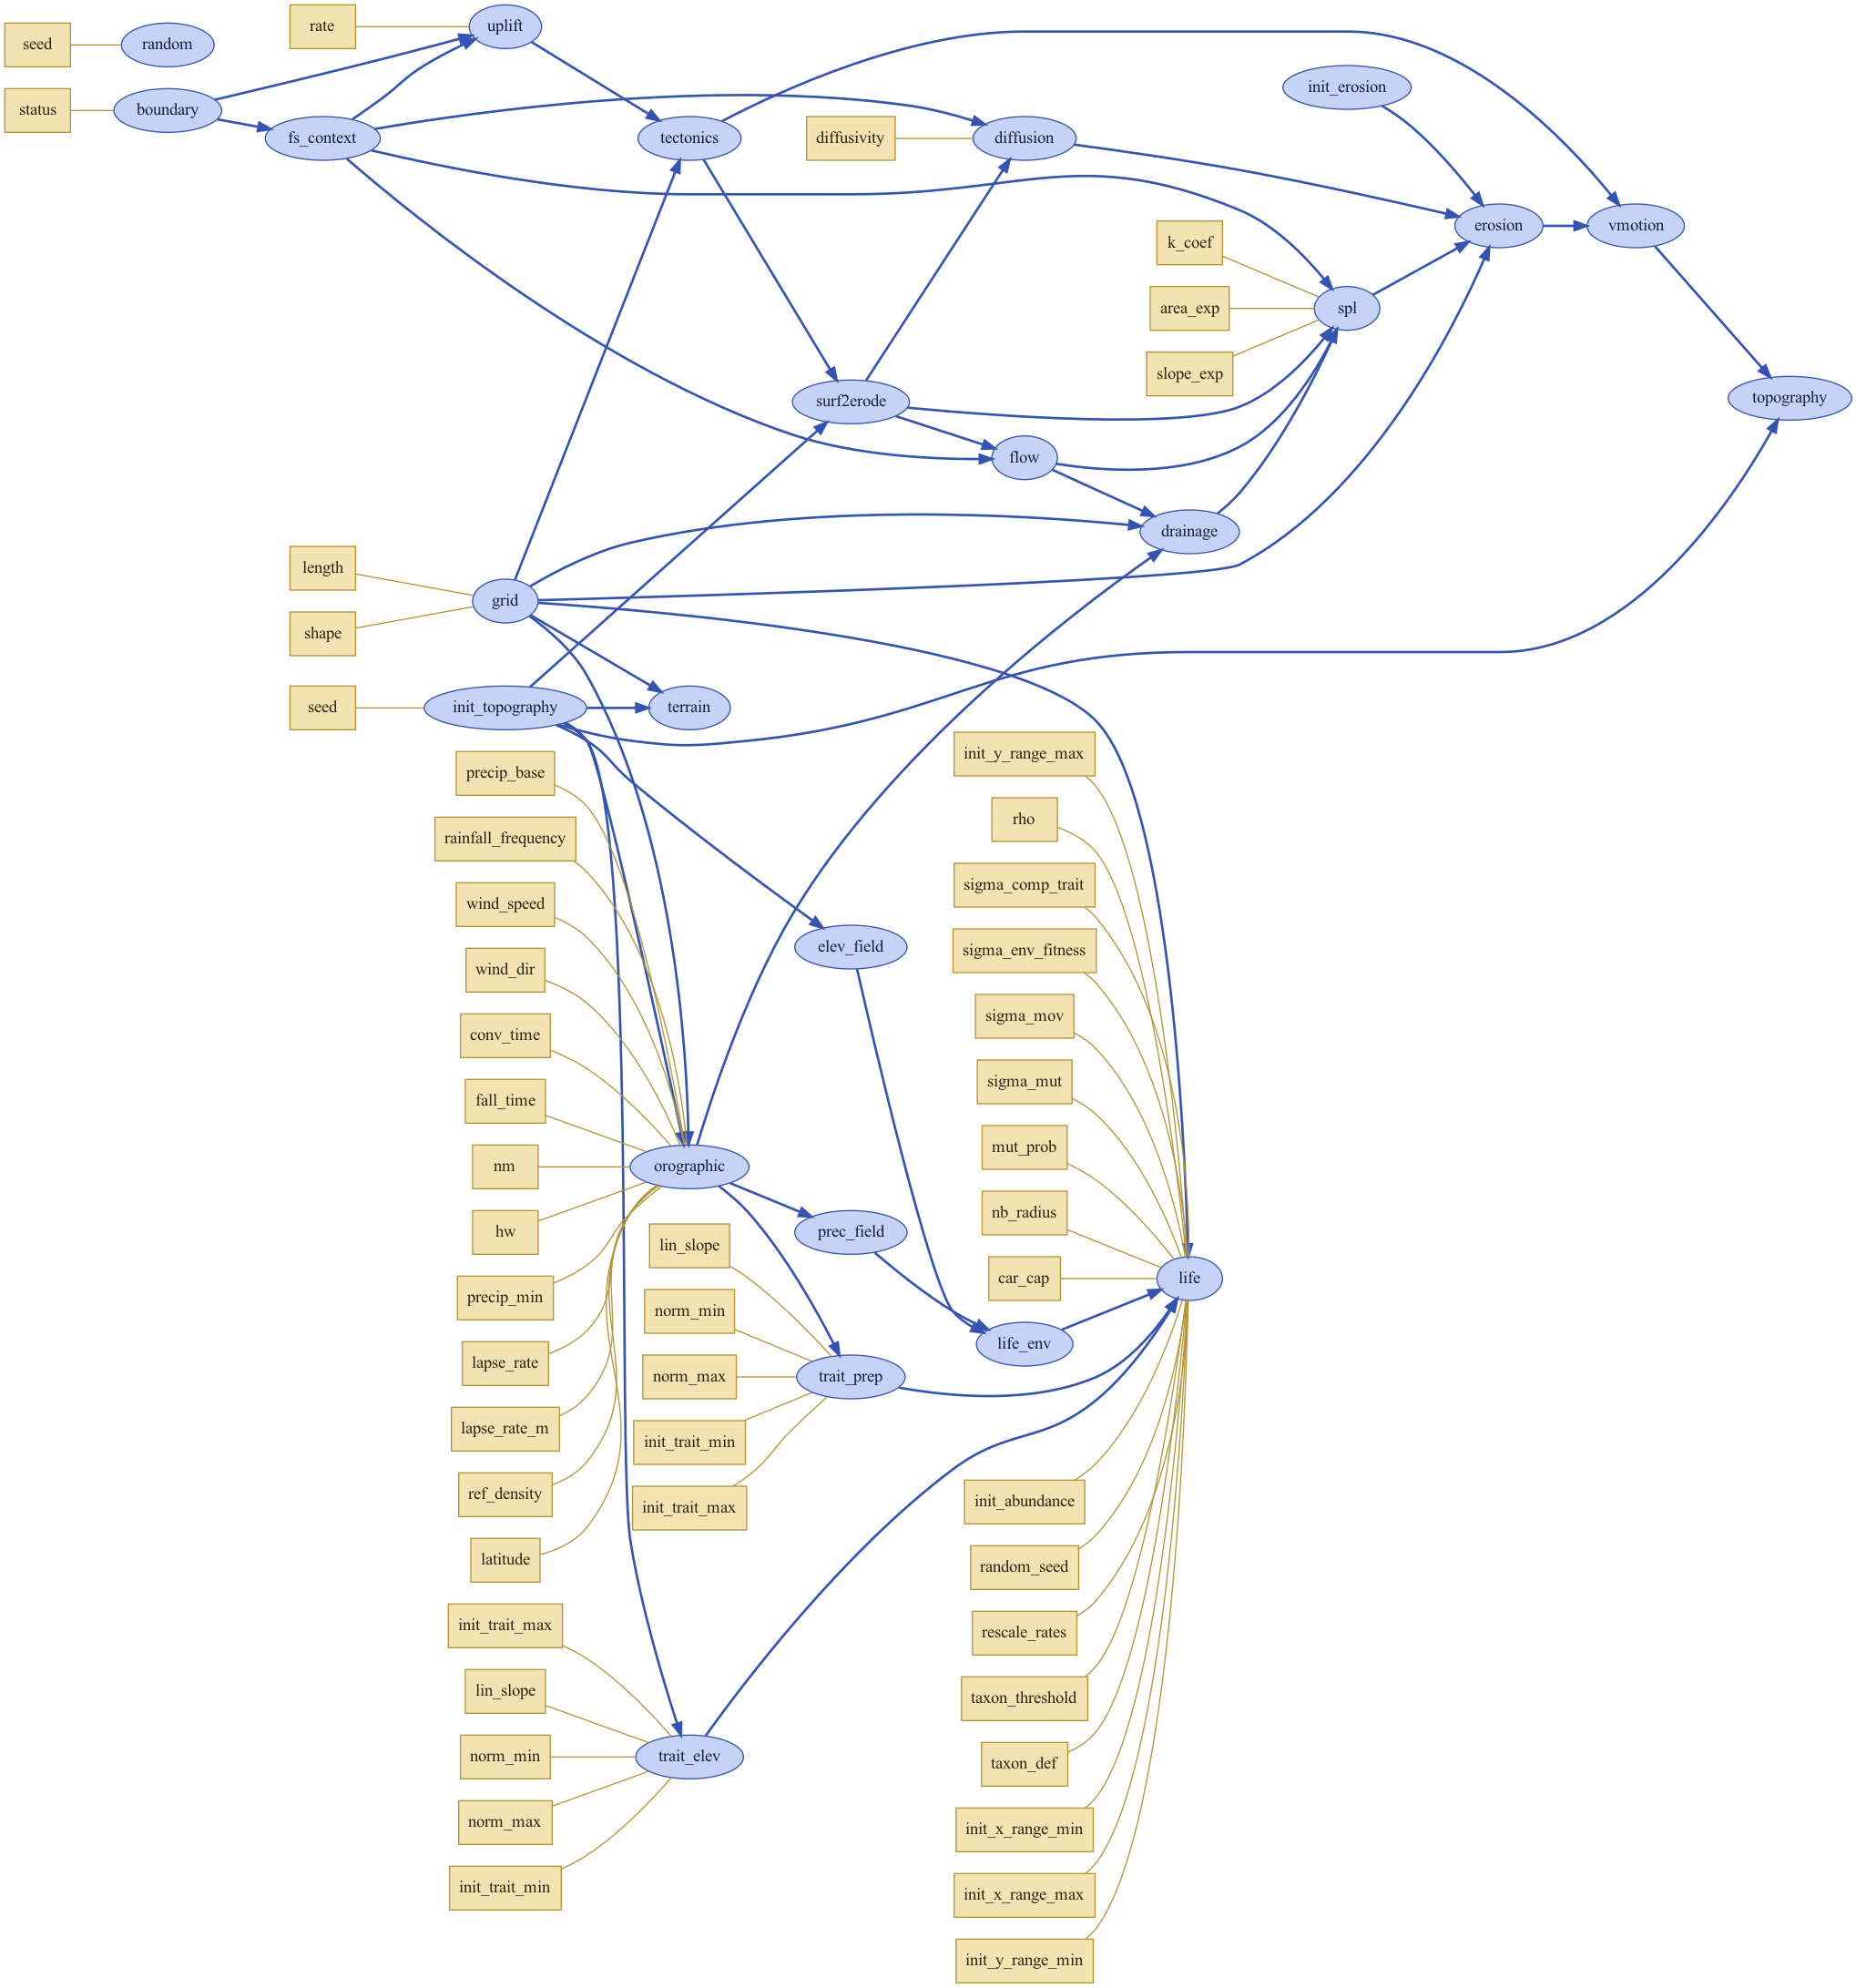

In [3]:
adaspec_IR12_model.visualize(show_inputs=True)

In [4]:
random_seed = 1234
time = np.linspace(0., 1e6, 1001)

lifespan = 50 # For example, vertebrates have a range of 211yr(Bowhead whale) to 0.15yr (pygmy goby)
               # For simplicity we assume a lifespan of 100 yr for one generation

ngen_dt = 1000/lifespan # number of generations in time step of the model yr/yr

in_ds = xs.create_setup(
    model=adaspec_IR12_model,
    clocks={
        'time': time,
        'out': time[::10]
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 101], 
        'grid__length': [1e5, 1e5], 
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 5e-3,
        'spl__k_coef':  1.8e-5,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'diffusion__diffusivity': 1e-2,
        'init_topography__seed': random_seed,
        'random':{'seed': random_seed},
        'orographic':{
            'rainfall_frequency':1,
            'latitude': 40, 
            'precip_base': 2.5,         
            'wind_speed': 15,          
            'wind_dir': 0,
            'nm': 0.1,
            'hw': 3000,
            'precip_min': 1e-4
        },
        'trait_elev': {
            'init_trait_min':0.25,
            'init_trait_max':0.25,
            'lin_slope':0.95,
            'norm_min':1,
            'norm_max':3700,
        },
        'trait_prep': {
            'init_trait_min':0.75,
            'init_trait_max':0.75,
            'lin_slope':0.95,
            'norm_min':1e-3,
            'norm_max':3.5,
        },
        'life': {
            'init_abundance': 100,
            'nb_radius': 2e4,
            'car_cap': 50,
            'sigma_mov': 1e4,
            'mut_prob': 0.005,
            'sigma_mut': 0.05, 
            'sigma_env_fitness': 0.25,
            'random_seed':random_seed,
            'taxon_threshold':0.075,
            'sigma_comp_trait':1.0
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'orographic__precip_rate':'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__traits': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [5]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=adaspec_IR12_model)

             0% | initialize 

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


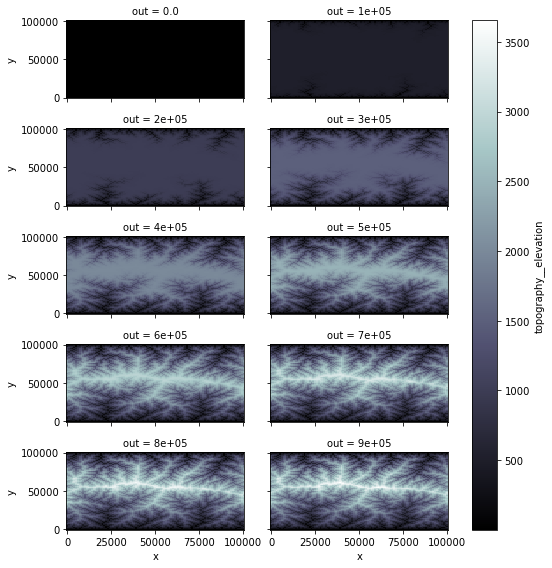

In [6]:
time_sel = np.arange(0, 1e6, 1e5)
elev_max = out_ds.topography__elevation.max()
out_ds.sel(out=time_sel).topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone')

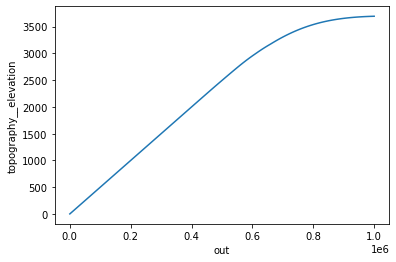

In [7]:
out_ds.topography__elevation.max(('x', 'y')).plot()

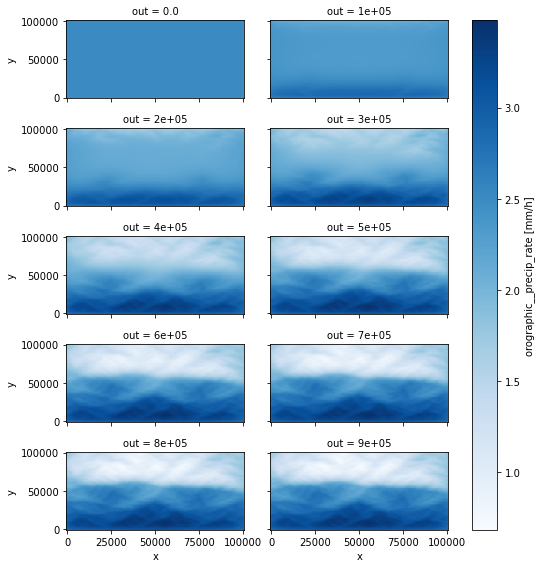

In [8]:
out_ds.sel(out=time_sel).orographic__precip_rate.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='Blues')

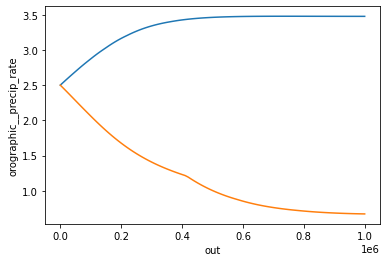

In [9]:
out_ds.orographic__precip_rate.max(('x', 'y')).plot()
out_ds.orographic__precip_rate.min(('x', 'y')).plot()

In [10]:
def get_dataframe(ds):
    individuals_data = {}
    for i in range(ds.life__traits.shape[2]):
        individuals_data['life__' + str(ds.trait[i].values.astype(str))] = ds.life__traits[:, :, i]
    ds = ds.assign(individuals_data)
    out_vars = ['life__taxon_id', 'life__ancestor_id', 'life__trait_elev', 'life__trait_prep', 'life__y', 'life__x']
    out_ds = ds[out_vars]

    dtf = (
        out_ds
            .to_dataframe()
            .rename(columns=lambda name: name.replace('life__', ''))
            .reset_index()
            .dropna()
    )
    return dtf

In [11]:
df1 = get_dataframe(out_ds)
df1

,out,ind,taxon_id,ancestor_id,trait_elev,trait_prep,y,x
0,0.0,0,1.0,0.0,0.250000,0.750000,29784.009062,97669.976670
1,0.0,1,1.0,0.0,0.250000,0.750000,61916.101637,38019.573502
2,0.0,2,1.0,0.0,0.250000,0.750000,30175.742962,92324.623376
3,0.0,3,1.0,0.0,0.250000,0.750000,17484.645113,26169.242386
4,0.0,4,1.0,0.0,0.250000,0.750000,49550.519522,31909.705841
...,...,...,...,...,...,...,...,...
61375,1000000.0,375,2525.0,2465.0,0.594942,0.572493,80240.690384,9071.410018
61376,1000000.0,376,2525.0,2465.0,0.594942,0.572493,63653.618650,35254.772346
61377,1000000.0,377,2525.0,2465.0,0.594942,0.572493,73470.437083,13337.766392
61378,1000000.0,378,2525.0,2465.0,0.594942,0.572493,26499.737525,11472.867543


## Plot population

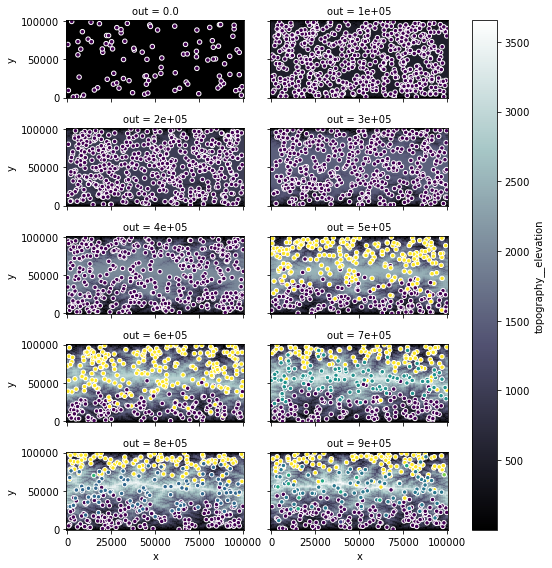

In [12]:
fg = (out_ds
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone'))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df1[df1.out==t]
    ax.scatter(pop.x, pop.y, c=pop.taxon_id, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

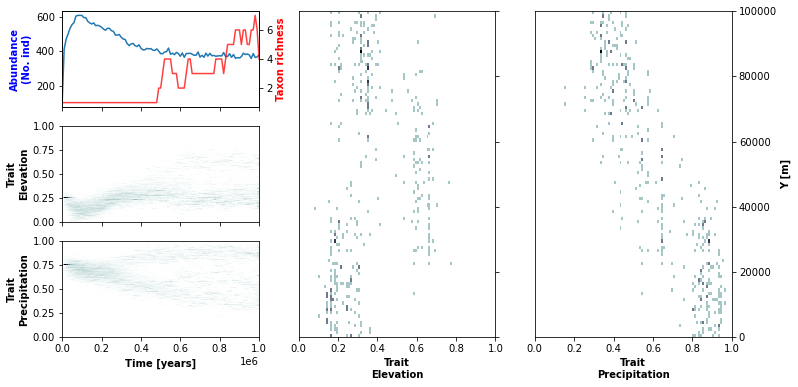

In [13]:
fig2, axs2 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, 1:].flatten():
    ax.remove()
axbig0 = fig2.add_subplot(gs2[0:, -2])
axbig1 = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df1.groupby('out').size())
axs2_2 = axs2[0,0].twinx()
axs2_2.plot(df1.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs2[1,0].hist2d(x=df1['out'], y=df1['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df1['out'], y=df1['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig0.hist2d(x=df1['trait_elev'].loc[df1['out']==max(df1['out'])], 
                             y=df1['y'].loc[df1['out']==max(df1['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig1.hist2d(x=df1['trait_prep'].loc[df1['out']==max(df1['out'])], 
                             y=df1['y'].loc[df1['out']==max(df1['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
axbig0.yaxis.set_tick_params(labelleft=False)
axbig1.yaxis.set_label_position("right")
axbig0.yaxis.tick_right()
axbig1.yaxis.tick_right()
axbig0.set_xlabel('Trait\nElevation', weight='bold')
axbig1.set_xlabel('Trait\nPrecipitation', weight='bold')
axbig1.set_ylabel('Y [m]', weight='bold')
axs2[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs2_2.set_ylabel('Taxon richness', weight='bold', color='red')
axs2[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs2[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs2[2,0].set_xlabel('Time [years]', weight='bold')

## Speciation with competition in an evolving landscape

In [14]:
with adaspec_IR12_model, xs.monitoring.ProgressBar():
    out_ds2 = in_ds.xsimlab.update_vars(input_vars={'life': {
            'sigma_comp_trait':0.2,
            'car_cap':30
        }
    }   
    ).xsimlab.run(check_dims='transpose')

             0% | initialize 

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [15]:
df2 = get_dataframe(out_ds2)

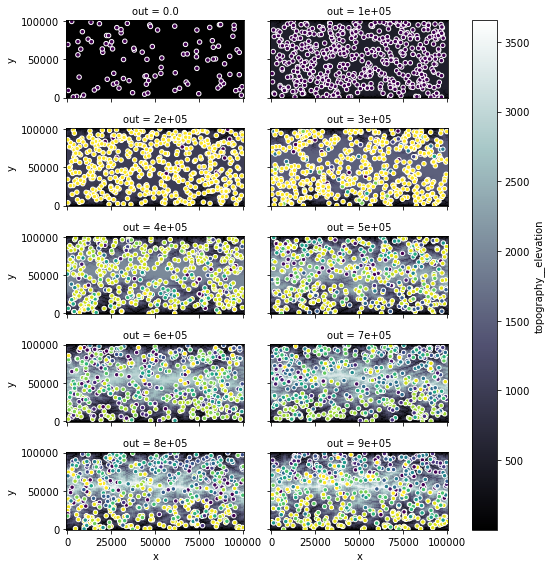

In [16]:
fg = (out_ds2
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone'))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.taxon_id, s=20, edgecolor='w')

Text(0.5, 0, 'Time [years]')

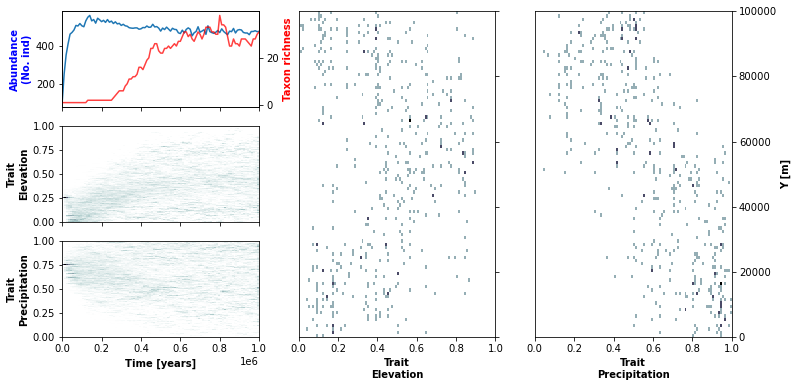

In [17]:
fig5, axs5 = plt.subplots(3, 3, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, 1:].flatten():
    ax.remove()
ax5big0 = fig5.add_subplot(gs5[0:, -2])
ax5big1 = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
axs5_2 = axs5[0,0].twinx()
axs5_2.plot(df2.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_elev'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_prep'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big0.hist2d(x=df2['trait_elev'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax5big1.hist2d(x=df2['trait_prep'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax5big0.yaxis.set_tick_params(labelleft=False)
ax5big1.yaxis.set_label_position("right")
ax5big0.yaxis.tick_right()
ax5big1.yaxis.tick_right()
ax5big0.set_xlabel('Trait\nElevation', weight='bold')
ax5big1.set_xlabel('Trait\nPrecipitation', weight='bold')
ax5big1.set_ylabel('Y [m]', weight='bold')
axs5[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs5_2.set_ylabel('Taxon richness', weight='bold', color='red')
axs5[1,0].set_ylabel('Trait\nElevation', weight='bold')
axs5[2,0].set_ylabel('Trait\nPrecipitation', weight='bold')
axs5[2,0].set_xlabel('Time [years]', weight='bold')

In [18]:
tree1 = df1.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [19]:
tree2 = df2.rename(columns={'out':'time'}).ptree.to_dendropy_tree()

In [20]:
df1.rename(columns={'out':'time'}).ptree.extract_taxon_summary()

,time,taxon_id,ancestor_id,trait_elev,trait_prep,abundance,node_type
0,0.0,1,0,0.250000,0.750000,100,root
1,10000.0,11,1,0.240051,0.749210,413,node
2,20000.0,21,11,0.226359,0.745164,471,node
3,30000.0,31,21,0.203684,0.737510,501,node
4,40000.0,41,31,0.177652,0.731030,535,node
...,...,...,...,...,...,...,...
248,990000.0,2468,2403,0.328114,0.541189,1,leaf
249,1000000.0,2523,2463,0.219261,0.865789,151,leaf
250,1000000.0,2524,2464,0.623224,0.560736,85,leaf
251,1000000.0,2525,2465,0.595389,0.587300,11,leaf


In [21]:
tree1.print_plot()

                                             /++++++++++++++++++++++++++++ 2523
                                     /++++++++                                 
                                   /++       \--------------------------++ 978 
                                   | |                                         
                                   | \-------------------------------+++++ 778 
                                   |                                           
++++++++++++++++++++++++++++++++++++ /---------------------------------+++ 688 
                                   | |                                         
                                   | |                       /----++++++++ 2179
                                   | |                      /+                 
                                   \++                      ||        /-++ 2398
                                     |        /++++++++++++++\+++++++++        
                                     |  

In [22]:
tree2.print_plot()

                                                               /+++++++++ 2689 
                                          /------------------+++               
                                          |                    \-------++ 1055 
                                          |                                    
                   /----------------------+                 /++++++++++++ 9453 
                   |                      |      /+++++++++++                  
                   |                      |    /++          \----------++ 5397 
                   |                      |    | |                             
                   |                      \+++++ \----------------------+ 1735 
                   |                           |                               
                   |                           \---------------++++++++++ 3730 
        /+++++++++++                                                           
        |          |  /-----------------

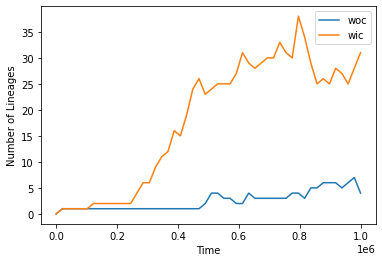

In [23]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
ltt2=[tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps1, ltt1, label='woc')
plt.plot(time_steps2, ltt2, label='wic')
plt.xlabel('Time')
plt.ylabel('Number of Lineages')
plt.legend()

In [24]:
bins = np.arange(0,50.1e3,2e3)

In [25]:
dft_sel=df1.groupby('out').get_group(1e6)

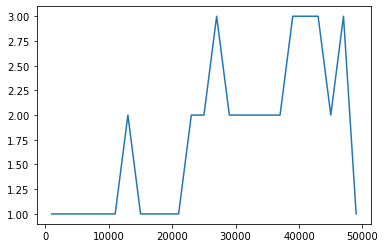

In [26]:
plt.plot((bins[:-1]+bins[1:])/2, dft_sel.groupby(pd.cut(dft_sel.y, bins)).taxon_id.nunique())

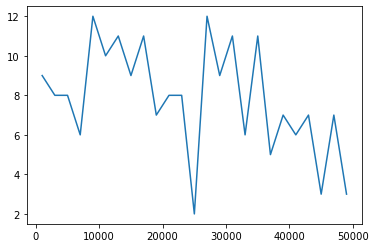

In [27]:
plt.plot((bins[:-1]+bins[1:])/2, dft_sel.groupby(pd.cut(dft_sel.y, bins)).size())